In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits

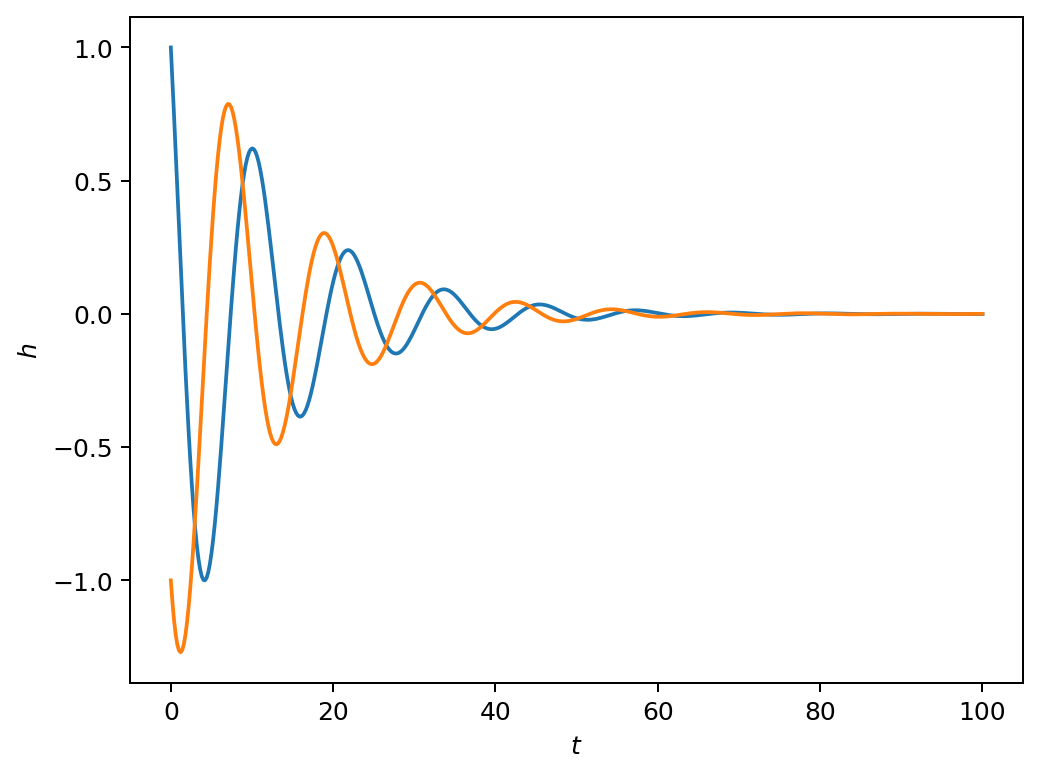

In [2]:
# Make a 305-like ringdown signal with the fundamental mode only
times = np.linspace(0,100,500)

amplitudes = [(1-1j)]
frequencies = qnmfits.qnm.omega_list([(2,2,0,1)], 0.7)

data = qnmfits.ringdown(times, 0, amplitudes, frequencies)

fig, ax = plt.subplots(dpi=180)
ax.plot(times, np.real(data))
ax.plot(times, np.imag(data))

ax.set_xlabel('$t$')
_ = ax.set_ylabel('$h$')

In [3]:
# Performing a fit with t0=0, we recover the injected complex amplitude:
best_fit = qnmfits.ringdown_fit(
    times,
    data,
    modes=[(2,2,0,1)],
    Mf=1,
    chif=0.7,
    t0=0
    )

print(f"Mismatch = {best_fit['mismatch']}")
print(f"Measured amplitude = {best_fit['C']}")

Mismatch = 0.0
Measured amplitude = [1.-1.j]


In [4]:
# But this changes for later start times:
best_fit = qnmfits.ringdown_fit(
    times,
    data,
    modes=[(2,2,0,1)],
    Mf=1,
    chif=0.7,
    t0=10
    )

print(f"Mismatch = {best_fit['mismatch']}")
print(f"Measured amplitude = {best_fit['C']}")

Mismatch = 0.0
Measured amplitude = [0.62114963+0.10776616j]


Both the magnitude and phase of the complex amplitude change when we go to a later start time. At the time of writing the code only reports the value of the amplitude *at the chosen value of $t_0$*, so of course its magnitude has decayed. We can understand the decay from the damping time of the QNM frequency:

In [5]:
# Repeat for a series of start times
t0_array = np.linspace(0,50,250)

mm_list = []
amp_list = []

for t0 in t0_array:
    
    best_fit = qnmfits.ringdown_fit(
        times,
        data,
        modes=[(2,2,0,1)],
        Mf=1,
        chif=0.7,
        t0=t0
        )
    
    mm_list.append(best_fit['mismatch'])
    amp_list.append(best_fit['C'])
    
mm_array = np.array(mm_list)
amp_array = np.array(amp_list)[:,0]

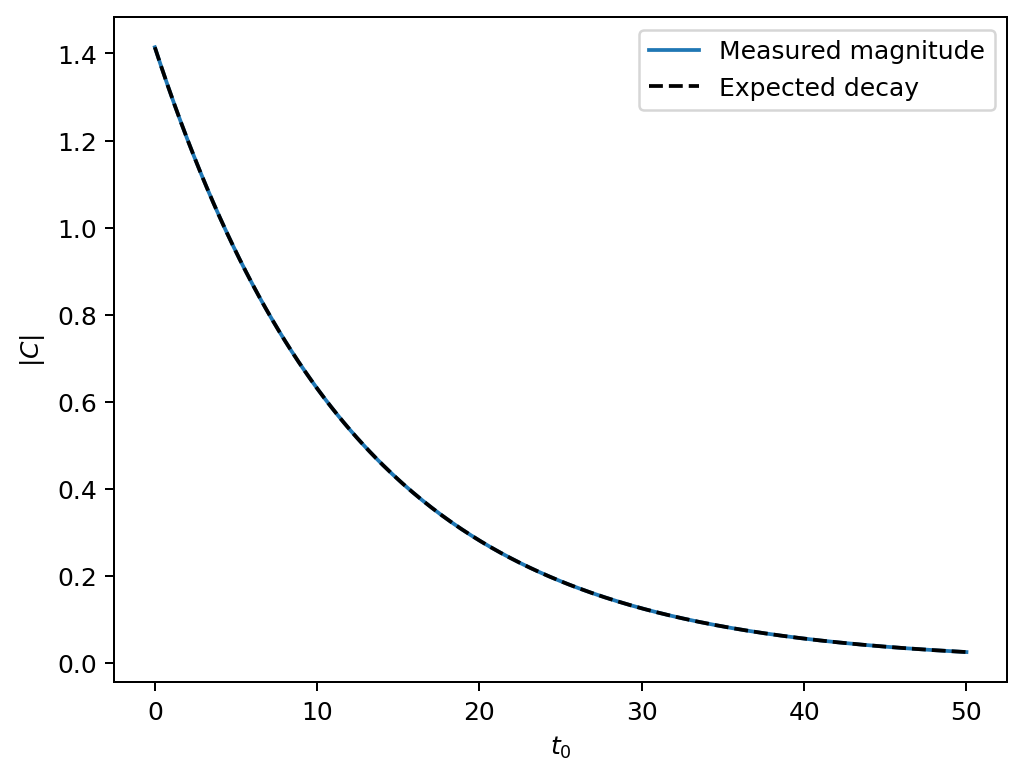

In [6]:
# We see the absolute value of the amplitude behaves as expected
fig, ax = plt.subplots(dpi=180)

ax.plot(t0_array, abs(amp_array), label='Measured magnitude')

# The expected magnitude decay from the QNM frequency
tau = -1/np.imag(frequencies[0])
expected_amp = abs(amp_array[0])*np.exp(-t0_array/tau)

ax.plot(t0_array, expected_amp, c='k', ls='--', label='Expected decay')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$|C|$')

_ = ax.legend()

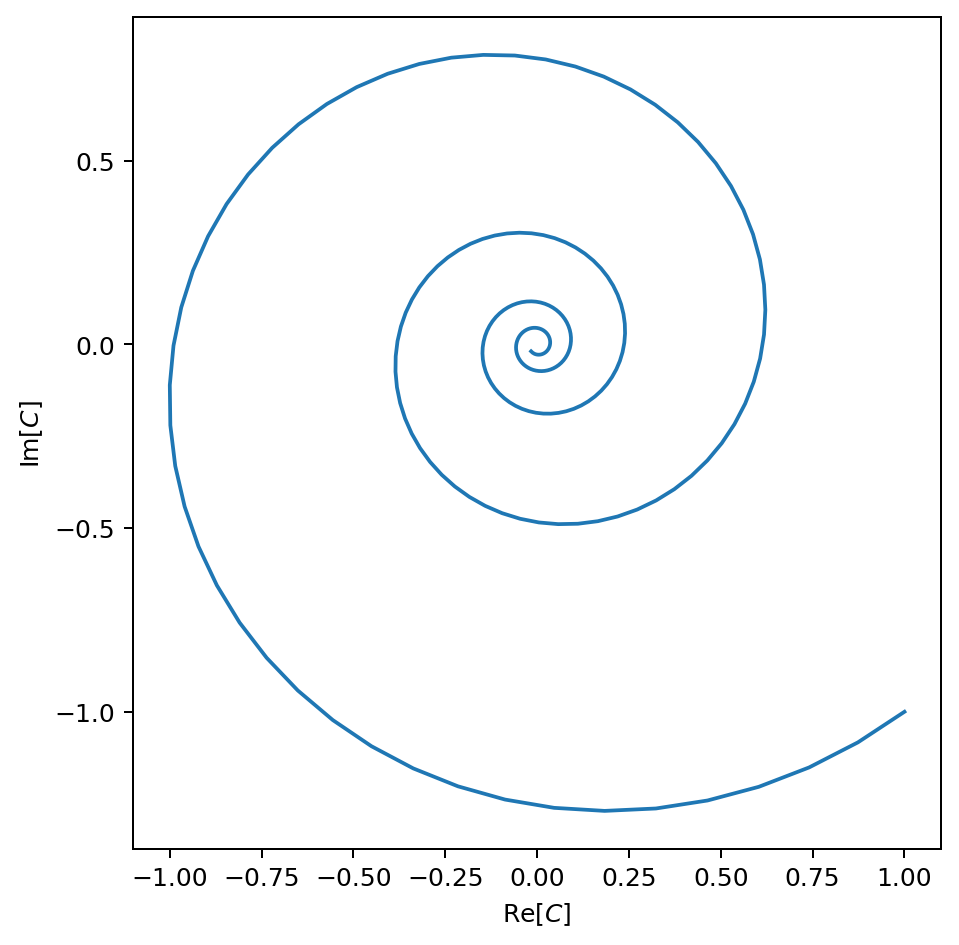

In [7]:
# And in the complex plane the amplitude spirals - the measured phase is
# always changing
fig, ax = plt.subplots(figsize=(6,6), dpi=180)
ax.set_aspect('equal')

ax.plot(np.real(amp_array), np.imag(amp_array))

ax.set_xlabel('$\mathrm{Re}[C]$')
_ = ax.set_ylabel('$\mathrm{Im}[C]$')

Say we want to report the amplitude at some fixed reference time $t_\mathrm{ref}$ which is not necessarily the same as $t_0$; $t_\mathrm{ref} = t_0 + \Delta t$. From a fit at $t_0$, we can get the expected amplitude at any time from our model for the ringdown:

$$ C(t) = C(t_0) e^{-i\omega(t-t_0)}, $$

and so the amplitude at $t_\mathrm{ref}$ is

$$ C(t_\mathrm{ref}) = C(t_0) e^{-i\omega(t_0 + \Delta t - t_0)} = C(t_0) e^{-i\omega\Delta t}. $$

If we write $\omega = 2\pi f - i/\tau$, we see the magnitude of the amplitude is scaled by $e^{-\Delta t/\tau}$ (as we saw before), and the phase is shifted by $e^{-i2\pi f \Delta t}$.

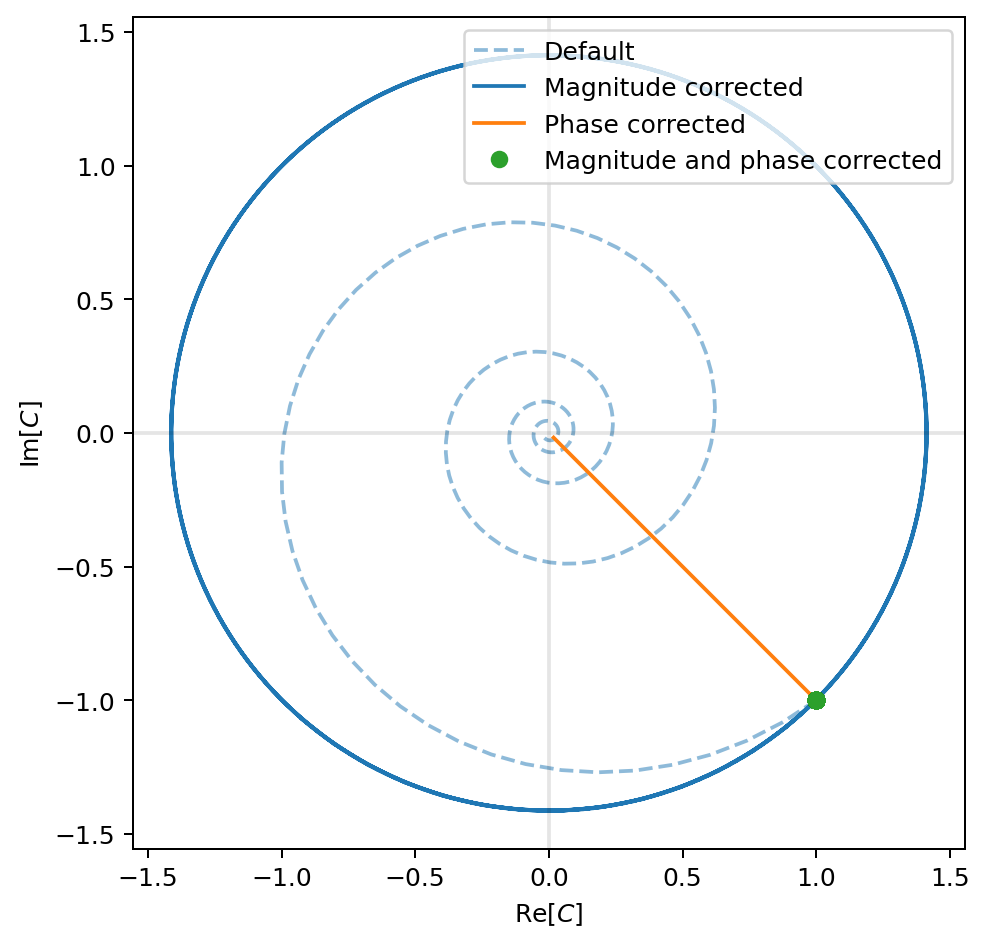

In [8]:
# Choose a reference time
t_ref = 0

# So we have a Delta t for each value in the t0 array:
dt_array = t_ref - t0_array

# Correcting the magnitude only:
tau = -1/np.imag(frequencies[0])
mag_corrected = amp_array*np.exp(-dt_array/tau)

# Correcting the phase change only:
phase_corrected = amp_array*np.exp(-1j*np.real(frequencies[0]*dt_array))

# Correcting the overall amplitude:
amp_corrected = amp_array*np.exp(-1j*frequencies[0]*dt_array)

fig, ax = plt.subplots(figsize=(6,6), dpi=180)
ax.set_aspect('equal')

ax.plot(np.real(amp_array), np.imag(amp_array), c='C0', ls='--', alpha=0.5, label='Default')
ax.plot(np.real(mag_corrected), np.imag(mag_corrected), c='C0', label='Magnitude corrected')
ax.plot(np.real(phase_corrected), np.imag(phase_corrected), c='C1', label='Phase corrected')
ax.plot(np.real(amp_corrected), np.imag(amp_corrected), marker='o', lw=0, c='C2', label='Magnitude and phase corrected')

ax.axvline(0, c='k', alpha=0.1)
ax.axhline(0, c='k', alpha=0.1)

ax.set_xlabel('$\mathrm{Re}[C]$')
ax.set_ylabel('$\mathrm{Im}[C]$')

_ = ax.legend()

Repeat for SXS:BBH:0305:

In [9]:
sim = qnmfits.SXS(ID=305, zero_time=(2,2))

/Users/eliot/Documents/Research/Ringdown/qnmfits/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


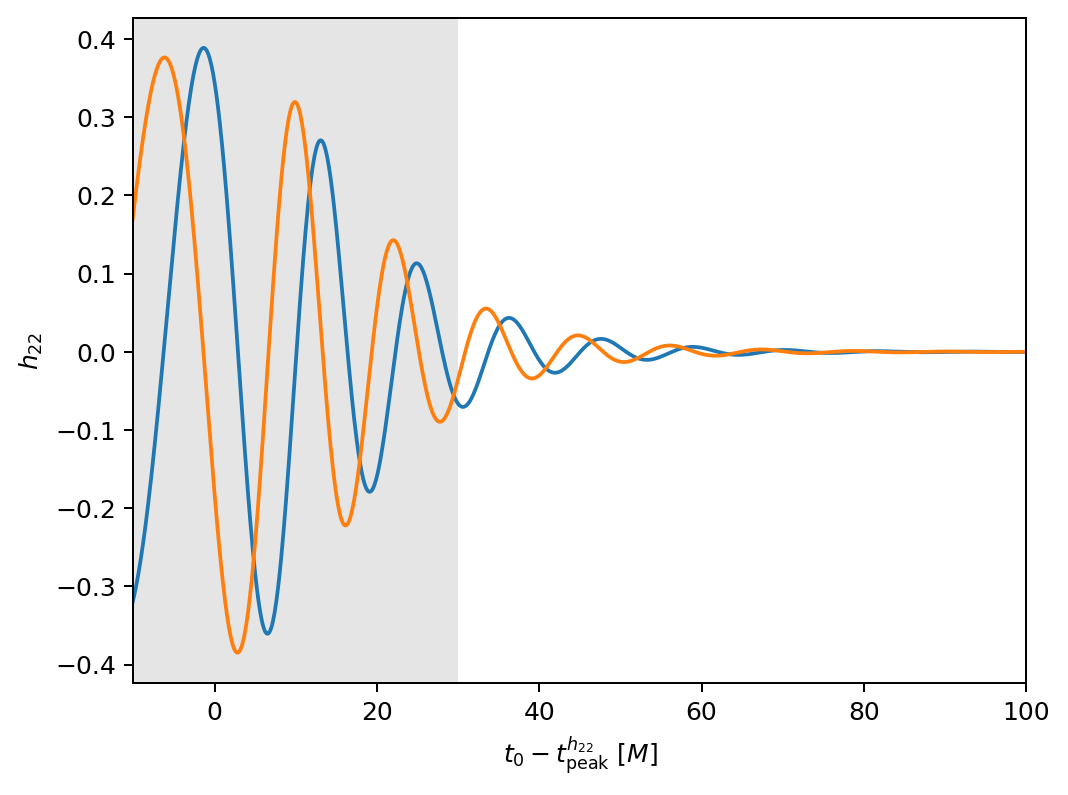

In [10]:
# Since we are only fitting the fundamental mode, we will fit to the late
# part of the ringdown only:

fig, ax = plt.subplots(dpi=180)

ax.plot(sim.times, np.real(sim.h[2,2]))
ax.plot(sim.times, np.imag(sim.h[2,2]))

ylim = ax.get_ylim()
ax.fill_betweenx([ylim[0],ylim[1]], x1=-20, x2=30, facecolor='k', alpha=0.1)

ax.set_xlim(-10,100)
ax.set_ylim(ylim)

ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
_ = ax.set_ylabel('$h_{22}$')

In [11]:
sim_frequency = qnmfits.qnm.omega(2, 2, 0, 1, sim.chif_mag, sim.Mf)

t0_array = np.linspace(30,80,250)

sim_mm_list = []
sim_amp_list = []

for t0 in t0_array:
    
    best_fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes=[(2,2,0,1)],
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=t0
        )
    
    sim_mm_list.append(best_fit['mismatch'])
    sim_amp_list.append(best_fit['C'])
    
sim_mm_array = np.array(sim_mm_list)
sim_amp_array = np.array(sim_amp_list)[:,0]

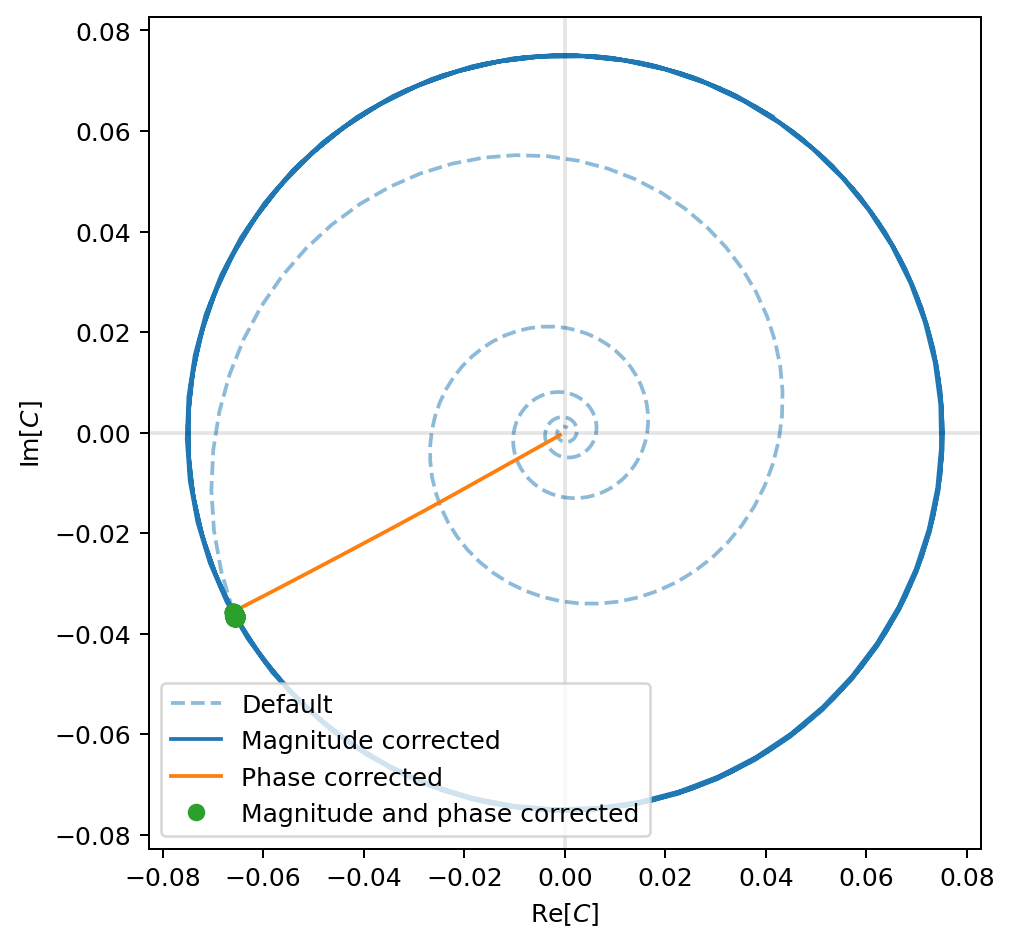

In [12]:
# Choose a reference time
t_ref = 30

# So we have a Delta t for each value in the t0 array:
dt_array = t_ref - t0_array

# Correcting the magnitude only:
tau = -1/np.imag(sim_frequency)
mag_corrected = sim_amp_array*np.exp(-dt_array/tau)

# Correcting the phase change only:
phase_corrected = sim_amp_array*np.exp(-1j*np.real(sim_frequency*dt_array))

# Correcting the overall amplitude:
amp_corrected = sim_amp_array*np.exp(-1j*sim_frequency*dt_array)

fig, ax = plt.subplots(figsize=(6,6), dpi=180)
ax.set_aspect('equal')

ax.plot(np.real(sim_amp_array), np.imag(sim_amp_array), c='C0', ls='--', alpha=0.5, label='Default')
ax.plot(np.real(mag_corrected), np.imag(mag_corrected), c='C0', label='Magnitude corrected')
ax.plot(np.real(phase_corrected), np.imag(phase_corrected), c='C1', label='Phase corrected')
ax.plot(np.real(amp_corrected), np.imag(amp_corrected), marker='o', lw=0, c='C2', label='Magnitude and phase corrected')

ax.axvline(0, c='k', alpha=0.1)
ax.axhline(0, c='k', alpha=0.1)

ax.set_xlabel('$\mathrm{Re}[C]$')
ax.set_ylabel('$\mathrm{Im}[C]$')

_ = ax.legend()